In [1]:
%matplotlib inline

In [2]:
import dipy.reconst.dti as dti

import os
import numpy as np
import math
import SimpleITK as sitk
from scipy import ndimage
import nibabel as nib
from PIL import Image
import scipy.misc
from scipy import signal
import warnings
import SimpleITK as sitk


In [3]:
from ndreg import *

In [4]:
def plot_rgb(im):
    plt.rcParams.update({'axes.labelsize': 'x-large',
                         'axes.titlesize': 'x-large'})

    if im.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = im.shape
        x = [int(shap[0]*0.35), int(shap[0]*0.51), int(shap[0]*0.65)]
        y = [int(shap[1]*0.35), int(shap[1]*0.51), int(shap[1]*0.65)]
        z = [int(shap[2]*0.35), int(shap[2]*0.51), int(shap[2]*0.65)]
    coords = (x, y, z)

    labs = ['Sagittal Slice (YZ fixed)',
            'Coronal Slice (XZ fixed)',
            'Axial Slice (XY fixed)']
    var = ['X', 'Y', 'Z']

    idx = 0
    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = plt.subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(im[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(im[:, pos, :], 90)
            else:
                image = im[:, :, pos]

            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0]/2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1]/2, image.shape[1] - 1])

            plt.imshow(image)

    fig = plt.gcf()
    fig.set_size_inches(12.5, 10.5, forward=True)
    return fig

def tiff_to_array(folder_path, input_path):
    """
    Function takes a single image (TIFF, or other also works), and returns
    the single image as a numpy array.  Called by tiff_stack_to_array.
    :param input_path: Single image file to open.
    :return: Numpy representation of image.
    """

    # The convert tag makes sure that we're dealing with floats, not uint8
    # This prevents underflow.
    im = Image.open(folder_path + input_path).convert("F")
    # im.show()

    imarray = np.array(im)
    # print(imarray)
    # print(imarray.dtype)
    
    return imarray


def tiff_stack_to_array(input_path):
    """
    Function takes input_path, which should should lead to a directory.
    Loads all TIFFs in input_path, then generates numpy arrays from the
    TIFF stack by calling tiff_to_array helper function.  Make sure TIFF
    images are ordered in numerical order.
    :param input_path: Folder or directory containing .tiff stack.
    :return: Numpy array of tiff stack.
    """
    im_list = [];
    for filename in os.listdir(input_path):
        if filename.endswith(".tif"):
            # print(os.path.join(directory, filename))
            im_arr = tiff_to_array(input_path, filename)
            im_list.append(im_arr)
        
    s = np.stack(im_list, axis=2)
    print s.shape
    return s

In [5]:
import os

In [13]:
inImg = tiff_stack_to_array('./')

(90, 90, 90)


In [14]:
type(inImg)

numpy.ndarray

In [15]:
inImg = sitk.GetImageFromArray(inImg)

In [16]:
imgWrite(inImg,'v571.nii')

In [17]:
rawImg = imgRead('v571.nii')

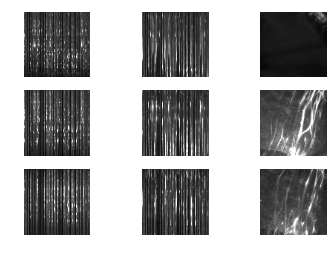

In [18]:
inThreshold = imgPercentile(inImg, 0.99)
imgShow(inImg, vmax=inThreshold)

In [19]:
from dipy.reconst.dti import *

# Tensor generated using matlab pipeline

In [46]:
tensorimg = nib.load('tensor.nii.gz')

In [47]:
print tensorimg.shape

(90, 90, 90, 6)


In [48]:
data = tensorimg.get_data()
print data.shape

(90, 90, 90, 6)


In [49]:
output = from_lower_triangular(data)
print output.shape

(90, 90, 90, 3, 3)


In [50]:
FA = fractional_anisotropy(output)
FA = np.clip(FA, 0, 1)
FA[np.isnan(FA)] = 0
print FA.shape

(90, 90, 90, 3)


In [51]:
evalues, evectors = decompose_tensor(output)
print evectors[..., 0, 0].shape
print evectors.shape[-2:]

(90, 90, 90)
(3, 3)


In [52]:
RGB = color_fa(FA[:, :, :, 0], evectors)

In [64]:
nib.save(nib.Nifti1Image(np.array(255 * RGB, 'uint8'), img.get_affine()), 'tensor_rgb_upper.nii.gz')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  """Entry point for launching an IPython kernel.


In [58]:
mainimg = imgRead('v571.nii')
mimg = nib.load('v571.nii')
affine = mimg.get_affine()
fa = nib.Nifti1Image(np.array(255 * RGB, 'uint8'), affine)
im = fa.get_data()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  This is separate from the ipykernel package so we can avoid doing imports until


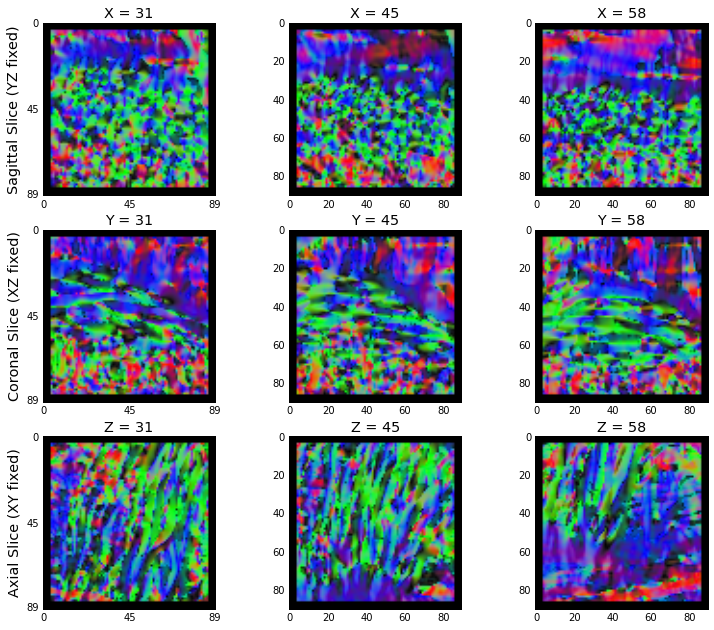

In [59]:
fig = plot_rgb(im)